### get facial landmark data

In [1]:
# connect google drive to colab

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# copy data to colab session

!cp /content/drive/MyDrive/Colab/data/data.zip .
!unzip data.zip

In [3]:
!mkdir -p weights

<b> 11GB of GPU RAM available</b>

In [4]:
!nvidia-smi

Sun Oct 24 17:48:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### load data

In [5]:
# import modules

import os, cv2
from os.path import join
import pandas as pd
import numpy as np
from numpy import array, zeros

from skimage.color import gray2rgb
from skimage.io import imread
from skimage.transform import resize

from tqdm.notebook import tqdm

In [6]:
# function to load images and keypoint data in training format
# returns image list and keypoint vector list for each face

def load_imgs_and_keypoints(img_fol, csv_path):
  im_ll=[]
  pt_ll=[]
  df=pd.read_csv(csv_path)  

  for name in tqdm(os.listdir(img_fol)):
    row=df[ df['filename']==name].iloc[0,1:].ravel()

    ipath=os.path.join(img_fol, name)
    im=cv2.cvtColor(cv2.imread(ipath), cv2.COLOR_BGR2RGB)
    H,W=im.shape[:2]
    im=cv2.resize(im, (100,100))/255
    im_ll.append(im)

    row2=[]
    div=None
    for i in range(len(row)):
      if i%2==0:
        div=W
      else:
        div=H
      row2.append(row[i]/div-0.5)

    pt_ll.append(row2)

  return im_ll, pt_ll


In [ ]:
# load train data

train_im_fol="data/train"
csv_path="data/gt.csv"

train_imgs, train_points = load_imgs_and_keypoints(train_im_fol, csv_path)

In [ ]:
# load test data

test_im_fol="data/test"
test_imgs, test_points = load_imgs_and_keypoints(test_im_fol, csv_path)

In [9]:
len(train_imgs), len(test_imgs)

(4800, 1200)

### visualize data

Normalized landmark coordinates
[-0.33636363636363636, -0.2787878787878788, -0.11212121212121212, -0.2787878787878788, 0.12727272727272732, -0.26666666666666666, 0.3151515151515152, -0.2606060606060606, -0.29393939393939394, -0.203030303030303, -0.19090909090909092, -0.2, -0.1303030303030303, -0.2, 0.13030303030303025, -0.19696969696969696, 0.21212121212121215, -0.19090909090909092, 0.296969696969697, -0.19090909090909092, 0.018181818181818188, -0.07272727272727275, -0.19393939393939397, 0.1575757575757576, 0.0, 0.15454545454545454, 0.16666666666666663, 0.14848484848484844]





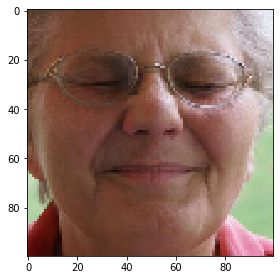

In [10]:
# Example of output

%matplotlib inline
from skimage.io import imshow

print("Normalized landmark coordinates")
print(train_points[100])
print("\n"*2)
imshow(train_imgs[100])

In [11]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

# function to visualize face and keypoints

def visualize_points(img, points):
  im2=img.copy()
  pt=points.copy()
  pt=[ (x+0.5)*100 for x in pt ]

  for i in range(0,len(pt),2):
    x1,y1=pt[i],pt[i+1]
    cir = plt.Circle((x1,y1), 1, color='r')
    plt.gca().add_patch(cir)

  plt.imshow(im2); plt.show()
    

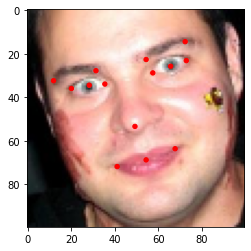

In [12]:
# train sample
visualize_points(train_imgs[123], train_points[123])

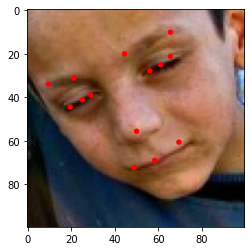

In [13]:
# test sample
visualize_points(test_imgs[1], test_points[1])

### augment data

In [14]:
# augment data

def flip_img(img, points):
  im2=img.copy()
  im2=cv2.flip(im2,1)
  pt=points.copy()
  pt=[ -x if i%2==0 else x for i,x in enumerate(pt) ]

  return im2,pt
  

In [15]:
# apply augmentation

aug_imgs_train=[]
aug_points_train=[]

for im,pt in zip(train_imgs, train_points):
  im2,pt2=flip_img(im,pt)
  aug_imgs_train+=[im, im2]
  aug_points_train+=[pt,pt2]

len(aug_imgs_train), len(aug_points_train)

(9600, 9600)

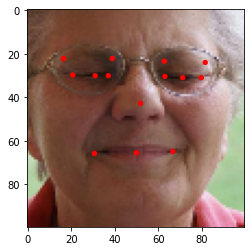

In [16]:
# visualize original image

visualize_points(aug_imgs_train[200], aug_points_train[200])

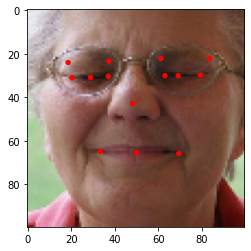

In [17]:
# visualize augmented image

visualize_points(aug_imgs_train[201], aug_points_train[201])

### design & create model

In [18]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16

In [19]:
from keras.models import Sequential, Model

from keras.layers import (
    Conv2D, MaxPooling2D, Flatten, BatchNormalization,
    Dense, Dropout, GlobalAveragePooling2D
)

In [32]:
# model architecture

def create_model():
  bb=ResNet50(input_shape=(100,100,3), include_top=False)
  x=GlobalAveragePooling2D()(bb.output)

  x=Dense(512*2, activation='relu')(x)
#   x=BatchNormalization()(x)
#   x=Dense(256*2, activation='relu')(x)

  x=Dense(28, activation='linear')(x)

  return Model(inputs=bb.input, outputs=x)


In [33]:
import keras
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import SGD, Adam

# create and compile model

model=create_model()
model.compile(optimizer=Adam(learning_rate=1E-3), loss='mean_squared_error', )

In [22]:
aug_imgs_train, aug_points_train= np.array(aug_imgs_train), np.array(aug_points_train)
test_imgs, test_points = np.array(test_imgs), np.array(test_points)

In [23]:
# A scheduler to set learning rate for given epoch

def scheduler(epoch, lr):
    if epoch < 10:
        return 1E-3
    elif epoch>=10 and epoch<30:
        return 1E-4
    elif epoch>=30 and epoch<40:
        return 1E-5
    else:
        return 1E-6


### train model

In [34]:
batch=96
total=aug_imgs_train.shape[0]

wt_path="weights/model_{epoch:02d}.h5"
c1=ModelCheckpoint(wt_path, save_weights_only=True),    
# c2=ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=1E-6)
c2=LearningRateScheduler(scheduler)        

history = model.fit(aug_imgs_train, aug_points_train, 
                    validation_data=(test_imgs, test_points), 
                    steps_per_epoch=total//batch, callbacks=[c1,c2],
                    epochs=30, verbose=1)

Epoch 1/30
100/100 [==============================] - 66s 600ms/step - loss: 0.0855 - val_loss: 0.7818
Epoch 2/30
100/100 [==============================] - 58s 585ms/step - loss: 0.0168 - val_loss: 0.0254
Epoch 3/30
100/100 [==============================] - 58s 585ms/step - loss: 0.0147 - val_loss: 0.0299
Epoch 4/30
100/100 [==============================] - 58s 584ms/step - loss: 0.0125 - val_loss: 0.0291
Epoch 5/30
100/100 [==============================] - 58s 585ms/step - loss: 0.0103 - val_loss: 0.0312
Epoch 6/30
100/100 [==============================] - 58s 585ms/step - loss: 0.0084 - val_loss: 0.0376
Epoch 7/30
100/100 [==============================] - 58s 585ms/step - loss: 0.0069 - val_loss: 0.0277
Epoch 8/30
100/100 [==============================] - 58s 585ms/step - loss: 0.0059 - val_loss: 0.0294
Epoch 9/30
100/100 [==============================] - 58s 585ms/step - loss: 0.0050 - val_loss: 0.0378
Epoch 10/30
100/100 [==============================] - 58s 584ms/step - l

No handles with labels found to put in legend.


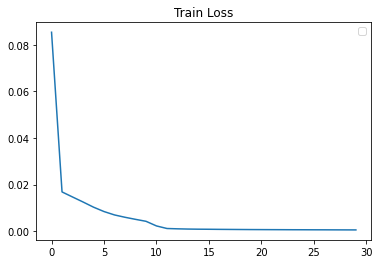

No handles with labels found to put in legend.


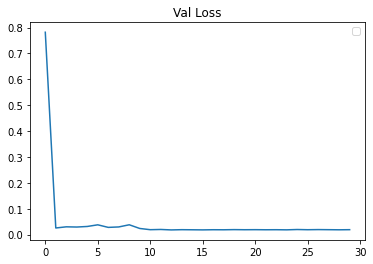

No handles with labels found to put in legend.


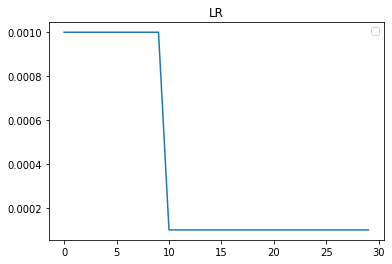

In [36]:
plt.title('Train Loss')
plt.plot(history.history['loss'])
plt.legend(); plt.show()

plt.title('Val Loss')
plt.plot(history.history['val_loss'])
plt.legend(); plt.show()

plt.title('LR')
plt.plot(history.history['lr'] )
plt.legend(); plt.show()

### evaluate model on test data

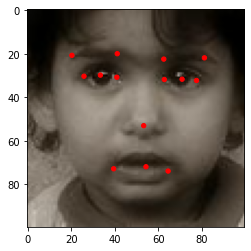

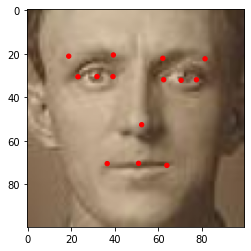

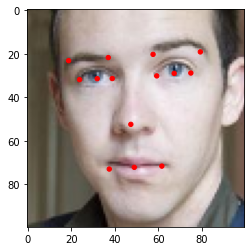

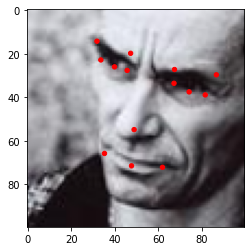

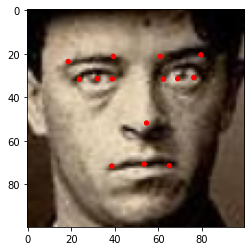

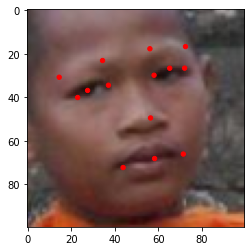

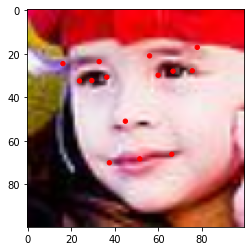

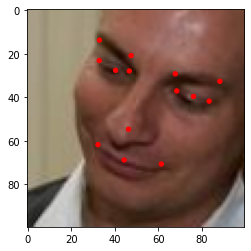

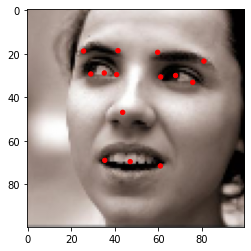

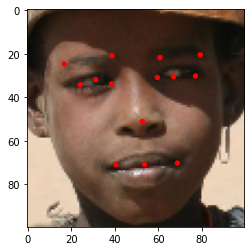

In [45]:
for im in test_imgs[:10]:
  im_np=np.expand_dims(im, axis=0)
  pt=np.squeeze(model.predict(im_np))
  visualize_points(im, pt)
